# Predicción Univariada y Multivariada de los Principales Índices Financieros del Mundo

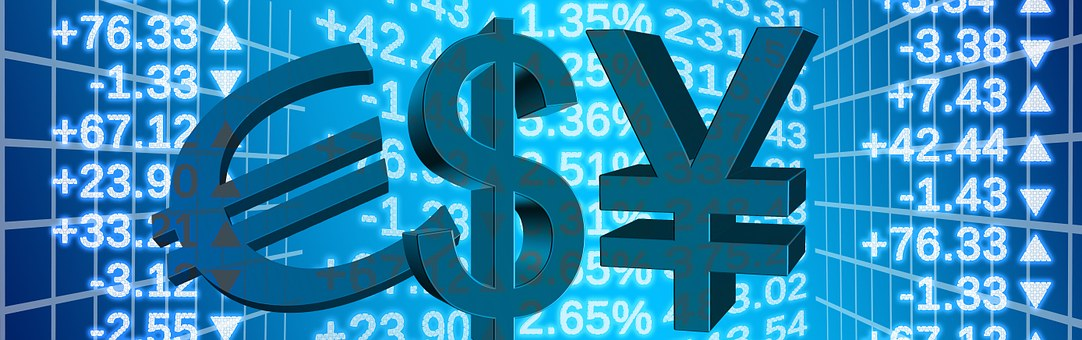

In [1]:
from IPython.display import Image
Image(filename='./img/imagenStock.jpg' ,  width= 1280)

### Carga de bibliotecas

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sb
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

### Carga del dataset

In [3]:
df = pd.read_csv("./inputs/dataset.csv", index_col=0, parse_dates=True, dayfirst= True)
df.head()

,MERV,BVSP,GSPC,NDX,FTSE,GDAXI,FCHI,N225,HSI,SSEC,BSESN,DEXARUS,DEXBZUS,DEXUSUK,DEXUSEU,DEXJPUS,DEXHKUS,DEXCHUS,DOLAR_BLUE
FECHA,,,,,,,,,,,,,,,,,,,
1997-07-02,824.109985,13260.0,904.030029,975.929993,4751.399902,3867.530029,2909.500000,20196.41992,NaN,1199.06,4333.899902,0.9998,1.0767,1.6670,1.1223,114.52,7.7472,8.3210,NaN
1997-07-03,831.440002,13285.0,916.919983,986.520020,4831.700195,3939.729980,2937.000000,20121.41016,15055.70020,1150.62,4323.459961,0.9994,1.0778,1.6885,1.1242,113.46,7.7445,8.3214,NaN
1997-07-04,837.950012,13494.0,NaN,NaN,4812.799805,3946.729980,2934.500000,19968.00000,14823.00000,1159.34,4323.819824,0.9995,NaN,NaN,1.1230,NaN,NaN,NaN,NaN
1997-07-07,841.690002,13502.0,912.200012,991.039978,4810.700195,4003.350098,2947.699951,19705.16992,14858.59961,1096.82,4291.450195,0.9998,1.0779,1.6870,1.1226,112.60,7.7428,8.3218,NaN
1997-07-08,846.330017,13617.0,918.750000,1005.809998,4758.500000,4030.100098,2929.800049,19853.89063,14792.20020,1109.67,4306.390137,0.9999,1.0790,1.6885,1.1180,112.76,7.7436,8.3219,NaN


### Transformaciones 

Aquí incluir el código desarrollado en TP2 para obtener las series transformadas (logaritmos naturales de los índices y tasas de retorno).

#### Preparamos el ambiente para obtener la serie de retornos y logaritmos de los índices.
Haremos un tratamiento de los datos similar al del práctico anterior. 

In [4]:
df = df[df.index.dayofweek < 5]

df_interpolate = df.copy()

for col in df.columns:
    
    df_temp = df[[col]]
    df_temp['new_index'] = np.array(range(len(df_temp)))
    
    df_temp_dropna=df_temp.dropna()

    y = np.array(df_temp[col])
    x = np.array(df_temp.new_index)

    y_dropna = np.array(df_temp_dropna[col])
    x_dropna = np.array(df_temp_dropna.new_index)
    
    f_lineal = interp1d(x_dropna, y_dropna, fill_value="extrapolate")
    f_cubic = interp1d(x_dropna, y_dropna, kind='cubic', fill_value="extrapolate")

    y_lineal = f_lineal(x)
    y_cubic = f_cubic(x)
    
    df_interpolate[col] = y_cubic
    del df_temp, df_temp_dropna, x, y, x_dropna, y_dropna, f_lineal, f_cubic, y_lineal, y_cubic

In [5]:
df = df_interpolate.copy()

In [6]:
cepo_1 = (df.index >= '2011-10-28') & (df.index <= '2015-12-16')
cepo_2 = (df.index >= '2019-09-01') & (df.index <= '2020-05-08')
cepo = (cepo_1 | cepo_2)
df['DEXARUS'][cepo] = df['DOLAR_BLUE']

df_us = pd.DataFrame(index=df.index)
df_us['MERV'] = df['MERV'] / df['DEXARUS'] # Divido porque el par esta en X/US
df_us['BVSP'] = df['BVSP'] / df['DEXBZUS']
df_us['FTSE'] = df['FTSE'] * df['DEXUSUK'] # Multiplico porque el par esta en US/X
df_us['GDAXI'] = df['GDAXI'] * df['DEXUSEU']
df_us['FCHI'] = df['FCHI'] * df['DEXUSEU']
df_us['N225'] = df['N225'] / df['DEXJPUS']
df_us['HSI'] = df['HSI'] / df['DEXHKUS']
df_us['SSEC'] = df['SSEC'] / df['DEXCHUS']
# df_us['BSESNUS'] = df['BSESN'] / df['DEX?'] Falta el DEX de rupias indias? 

#A continuación agregamos los índices GSPC y NDX.
df_us['GSPC'] = df['GSPC']
df_us['NDX'] = df['NDX']

#### Definimos los dataframes df_ret y df_ln

In [7]:
df_ret = df_us.pct_change().replace(np.nan,0)
df_ln = np.log(df_us)

In [8]:
df_ret.head()

,MERV,BVSP,FTSE,GDAXI,FCHI,N225,HSI,SSEC,GSPC,NDX
FECHA,,,,,,,,,,
1997-07-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1997-07-03,0.009298,0.000863,0.030016,0.020393,0.011161,0.005594,-0.060765,-0.040444,0.014258,0.010851
1997-07-04,0.007729,0.015781,-0.003102,0.000707,-0.001918,-0.001982,-0.015259,0.007547,-0.003921,0.000044
1997-07-07,0.004162,0.000452,-0.002136,0.013985,0.004140,-0.011247,0.002421,-0.053943,-0.001231,0.004538
1997-07-08,0.005412,0.007489,-0.009971,0.002557,-0.010145,0.006118,-0.004572,0.011704,0.007180,0.014904


In [9]:
df_ln.head()

,MERV,BVSP,FTSE,GDAXI,FCHI,N225,HSI,SSEC,GSPC,NDX
FECHA,,,,,,,,,,
1997-07-02,6.714504,9.418606,8.977220,8.375751,8.091117,5.172511,7.635219,4.970511,6.806863,6.883391
1997-07-03,6.723759,9.419469,9.006794,8.395939,8.102216,5.178089,7.572529,4.929226,6.821020,6.894184
1997-07-04,6.731459,9.435127,9.003688,8.396646,8.100296,5.176106,7.557152,4.936744,6.817091,6.894227
1997-07-07,6.735612,9.435578,9.001550,8.410534,8.104428,5.164795,7.559571,4.881292,6.815859,6.898755
1997-07-08,6.741009,9.443040,8.991528,8.413088,8.094231,5.170894,7.554989,4.892927,6.823014,6.913548


# Trabajo Práctico N°4: Aprendizaje Supervisado

## Introducción

En los prácticos 1 y 2 se analizaron las series originales y se les realizaron diversas transformaciones. Luego, a partir de las series preprocesadas, en el práctico 3 se realizaron las divisiones de los conjuntos de datos y se obtuvieron los pronósticos _average_ y _naive_ y se comparó su desempeño con el de los modelos ARIMA.

Este práctico es una continuación del práctico 3. El objetivo principal de mismo es estimar modelos relativamente mas avanzados y comparar su desempeño con los trabajados previamente. 

Los modelos sugeridos son:

Modelos estadísticos multivariantes

#### Modelo VAR

Por un lado, se pueden considerar los modelos vectoriales autorregresivos (VAR) que son la extensión natural de los modelos ARMA para series multivariantes. Empleando los mismos se pueden modelar las tasas de rendimiento de varios índices financieros en forma simultánea. 

Formalmente, Se conoce como modelo de vectores autorregresivos a un proceso estocástico $k$-dimensional $x_t$ tal que

$$x_t= A_1 x_{t-1} +...+A_p x_{t-p} + u_t,$$

donde las $A_i$, para $i= 1,...,p$, son matrices de orden $k \times k$ y $u_t$ es un proceso ruido blanco de dimensión $k$; o sea que $E(u_t)=0$, $E(u_t u_t') = \Sigma_u$ y $E(u_tu_s)=0$ para $s \neq t$.[Mas detalles](https://otexts.com/fpp2/VAR.html)

#### Modelos VECM

En caso de estimar modelos para series no estacionarias, como es el caso de los logaritmos naturales de los retornos, los modelos VAR no son adecuados por razones similares a las estudiadas en el caso de los modelos ARIMA. Se podría aplicar un modelo VAR para las series diferenciadas, pero para no perder la información sobre las potenciales relaciones de largo plazo entre dichas series es recomendable trabajar con modelos vectoriales de corrección de errores (VECM). 

Formalmente:

Dado el modelo VAR no estacionario (o sea que las series componetes de $y_t$ son no estacionarias) $$y_t= A_1 y_{t-1}+...+A_p y_{t-p}+ u_t,$$

el mismo puede ser reescrito en forma de Modelo de Corrección de Errores (VECM) $$\Delta y_t=\Pi y_{t-1}+ \Gamma_1 \Delta y_{t-1}+...+\Gamma_p \Delta y_{t-p+1}+ u_t.$$

Siendo  $\Pi = -(I_k - A_1 - ... - A_p)$, $r(\Pi)= r$, con $0 \leq r \leq k$, $u_t \sim N(0, \Sigma_u)$ y las $\Gamma_i=-(A_{i+1}+...+A_p)$, para $i=1,...,p-1$ son matrices de parámetros de orden $k \times k$. Si $\Pi$ tiene rango $r$, puede ser expresada como el producto $\alpha \beta'$, siendo $\alpha$ y $\beta$ matrices de orden $k\times r$ de rango $r$. En dicho caso, se dice que el proceso $y_t$ es cointegrado con rango $r$. Las matrices $\beta$ y $\alpha$ son conocidas como matriz de cointegración y matriz de cargas, respectivamente.

La importancia de la representación en forma de modelo de correción de errores radica en que permite expresar a $\Delta y_t$ como la suma de dos componentes (aparte de $u_t$): 1) $\Pi y_{t-1}$ que muestra relaciones de equilibrio de largo plazo y 2) $\Gamma_1 \Delta y_{t-1}+...+\Gamma_p \Delta y_{t-p+1}$ que capta el ajuste de corto plazo.

Respecto a las relaciones de largo plazo, las mismas son conocidas como relaciones de cointegración y consisten en combinaciones lineales estacionarias $z_t=\beta'y_t$ de las series $y_t$ (las cuales son no estacionarias).

#### LSTM

Las redes Long Short Term Memory son un caso particular de las Redes Neuronales Recurrentes y buscan reolver el problema del decaimiento del gradiente. Por lo general las referencias son bastante confusas, pero estos enlaces son relativamente claros: [Link1](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) - [Link2](https://medium.com/@jcrispis56/introducci%C3%B3n-al-deep-learning-parte-3-redes-neuronales-recurrentes-7da543c3b181).



## Consignas


A partir de las series transformadas (logaritmos naturales de los índices y tasas de retorno), se proponen actividades orientadoras y algunos links con "ayudas", sin perjuicio de que se puedan incorporar análisis adicionales y consultar otras fuentes. 

Es recomendable realizar la división entre datos de entrenamiento y test usando un punto fijo en el tiempo para reducir la carga computacional. En forma opcional luego se puede implementar lo mismo con Walk-Forward Validation.

**Se pide:**

#### Modelo VAR

Entrenar un modelo VAR para las series correspondientes a los retornos de los índices. [Documentación](https://www.statsmodels.org/stable/vector_ar.html?highlight=var#module-statsmodels.tsa.vector_ar.var_model) - [Material complementario](https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/).

Hiperparámetros a considerar:

* El hiperparámetro mas importante es $p$, o sea la cantidad de retardos.
* Otro hiperparámetro es la especificación de la parte determinística, o sea si se incluye una constante, o una tendencia determinística.

La selección de los hiperparámetros se puede basar en las métricas previamente usadas: Error Cuadrático Medio, Error Absoluto Medio y Error Absoluto Mediano, o en criterios de información. 
 
#### Modelo VECM

Entrenar un modelo VECM para los logaritmos de los índices. [Documentación](https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.vecm.VECM.html).

Hiperparámetros:

* La cantidad de retardos.
* Especificación de la parte determinística.
* Cantidad de relaciones de cointegración.

La selección de los hiperparémetros se puede realizar como en el modelo VAR, aunque en el caso de la cantidad de relaciones de cointegración es usual emplear la [Prueba de Johansen](https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.vecm.coint_johansen.html?highlight=statsmodels%20tsa%20vector_ar%20vecm%20coint_johansen#statsmodels.tsa.vector_ar.vecm.coint_johansen).

#### LSTM

Entrenar una red neuronal tipo LSTM univariante. [Ayuda](https://towardsdatascience.com/how-not-to-predict-stock-prices-with-lstms-a51f564ccbca).

Entrenar una red neuronal tipo LSTM multivariante. [Ayuda](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/).
    
#### Evaluar el desempeño de los modelos. ¿Se pudo superar a los modelos "baseline"?

**Opcional:**

Implementar un procedimiento en dos etapas para combinar las estimaciones de un modelo VAR con LSTM (para las tasas de rendimiento) y comparar el desempeño con los de LSTM y VAR.
[Descripción del procecimiento](https://towardsdatascience.com/combine-lstm-and-var-for-multivariate-time-series-forecasting-abdcb3c7939b) - [Código](https://github.com/cerlymarco/MEDIUM_NoteBook/blob/master/LSTM_VAR/LSTM_VAR.ipynb).

## Fecha de entrega

- __Versión preliminar: 11/10__ 

- __Version final: 18/10__

## Condiciones de entrega

Realizar un informe en el cual se presenten los resultados y conclusiones del análisis realizado. El mismo debe estar pensado para un público técnico pero que desconoce los aspectos propios del problema a resolver tal como los compañeros de clase. Dicho informe puede ser un notebook, a condición de que en el mismo se efectúe un análisis escrito suficientemente detallado de los resultados. 


# Desarrollo

In [88]:
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

n_test = 500
ret_train_data, ret_test_data = train_test_split(df_ret, n_test)
ln_train_data, log_test_data = train_test_split(df_ln, n_test) 

print(len(log_test_data))

500


## Modelo VAR

In [11]:
var_model = VAR(ret_train_data)
var_model_results = var_model.fit(maxlags=15, ic='aic')
var_model_lag_order = var_model_results.k_ar
var_model_forecast_input_data = ret_train_data.values[-var_model_lag_order:]
var_model_pred = var_model_results.forecast(y=var_model_forecast_input_data, steps=n_test)
var_model_pred = (pd.DataFrame(var_model_pred, index=ret_test_data.index, columns=ret_test_data.columns + '_pred'))

In [12]:
print(var_model_pred)

            MERV_pred  BVSP_pred  FTSE_pred  GDAXI_pred  FCHI_pred  N225_pred  \
FECHA                                                                           
2018-06-11   0.001984   0.006651   0.003175    0.002225   0.002355   0.001320   
2018-06-12  -0.004828   0.003171  -0.001405   -0.001093  -0.001012   0.000267   
2018-06-13  -0.000284   0.003088   0.001803    0.001150   0.002171  -0.000225   
2018-06-14  -0.000854  -0.001485  -0.001079   -0.000714  -0.001291   0.000433   
2018-06-15   0.000995  -0.000968   0.000040    0.000681   0.000371  -0.000652   
...               ...        ...        ...         ...        ...        ...   
2020-05-04   0.000340   0.000380   0.000132    0.000347   0.000244   0.000141   
2020-05-05   0.000340   0.000380   0.000132    0.000347   0.000244   0.000141   
2020-05-06   0.000340   0.000380   0.000132    0.000347   0.000244   0.000141   
2020-05-07   0.000340   0.000380   0.000132    0.000347   0.000244   0.000141   
2020-05-08   0.000340   0.00

In [13]:
# Mean absolute error
mae = mean_absolute_error(ret_test_data['MERV'], var_model_pred['MERV_pred'])
print('MAE: %f' % mae)

# Mean squared error
mse = mean_squared_error(ret_test_data['MERV'], var_model_pred['MERV_pred'])
print('MSE: %f' % mse)

# Root mean squared error
rmse = math.sqrt(mse)
print('RMSE: %f' % rmse)

MAE: 0.025076
MSE: 0.001588
RMSE: 0.039852


## Modelo VECM

El modelo 'Vector Error Correction Model' supone la no estacionalidad de las series, entonces es un modelo aplicable a las series de los Logaritmos.
Antes que nada, importamos la librería.

In [14]:
from statsmodels.tsa.api import VECM

Para conocer la cantidad de relaciones de cointegración (el 3er hiperparámetro del modelo VECM), lo que podemos hacer es el Test de Johansen.
Nuestro valor de medida, ya sea max_eigenvalue o trace_stat, debe ser mayor al valor crítico para poder rechazar la hipótesis nula que el número de correlaciones es menor o igual a n.
https://docs.w3cub.com/statsmodels/generated/statsmodels.tsa.vector_ar.vecm.coint_johansen/

In [58]:
# Example 14.3 Cointegration Test: The Johansen Approach 

data = df_ln

from statsmodels.tsa.vector_ar.vecm import coint_johansen

"""
    Johansen cointegration test of the cointegration rank of a VECM

    Parameters
    ----------
    endog : array_like (nobs_tot x neqs)
        Data to test
    det_order : int
        * -1 - no deterministic terms - model1
        * 0 - constant term - model3
        * 1 - linear trend
    k_ar_diff : int, nonnegative
        Number of lagged differences in the model.
"""

def joh_output(res):
    output = pd.DataFrame([res.lr1, res.lr2],
                          index=["trace_stat", 'max_eig_stat'])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat")
    for i in range(len(res.cvt)):
        print(i, res.cvt[i])
    print("\n")
    print("Critical values(90%, 95%, 99%) of max_eig_stat")
    for i in range(len(res.cvm)):
        print(i, res.cvm[i])
    print("--------------------------------------------------------------")


# Model 3 (2 lag-difference used = 3 lags VAR or VAR(3) model)
# with constant/trend (deterministc) term
joh_model3 = coint_johansen(data,0,2) # k_ar_diff +1 = K
joh_output(joh_model3)
# Model 2: with linear trend only
joh_model2 = coint_johansen(data,1,2) # k_ar_diff +1 = K
joh_output(joh_model2)

# Model 1: no constant/trend (deterministc) term
joh_model1 = coint_johansen(data,-1,2) # k_ar_diff +1 = K
joh_output(joh_model1)

   trace_stat  max_eig_stat
0  222.994557     60.226823
1  162.767733     46.488569
2  116.279164     41.612700
3   74.666464     19.875803
4   54.790661     17.547156
5   37.243506     14.252003
6   22.991503      9.973592
7   13.017911      6.896086
8    6.121825      5.475145
9    0.646680      0.646680 

Critical values(90%, 95%, 99%) of trace_stat
0 [232.103  239.2468 253.2526]
1 [190.8714 197.3772 210.0366]
2 [153.6341 159.529  171.0905]
3 [120.3673 125.6185 135.9825]
4 [ 91.109   95.7542 104.9637]
5 [65.8202 69.8189 77.8202]
6 [44.4929 47.8545 54.6815]
7 [27.0669 29.7961 35.4628]
8 [13.4294 15.4943 19.9349]
9 [2.7055 3.8415 6.6349]


Critical values(90%, 95%, 99%) of max_eig_stat
0 [61.2041 64.504  71.2525]
1 [55.2412 58.4332 64.996 ]
2 [49.2855 52.3622 58.6634]
3 [43.2947 46.2299 52.3069]
4 [37.2786 40.0763 45.8662]
5 [31.2379 33.8777 39.3693]
6 [25.1236 27.5858 32.7172]
7 [18.8928 21.1314 25.865 ]
8 [12.2971 14.2639 18.52  ]
9 [2.7055 3.8415 6.6349]
---------------------------

## CONSULTAR 
Tengo que elegir Cantidad de relaciones de cointegracion = 1 ?? Links: https://blog.quantinsti.com/johansen-test-cointegration-building-stationary-portfolio/?utm_campaign=News&utm_medium=Community&utm_source=DataCamp.com , http://cruncheconometrix.blogspot.com/2018/03/time-series-analysis-lecture-4-part-1.html
Está bien hacer el Test de Johansen con todos los datos? O hacerlo solamente con los datos de entrenamiento ?

Encontré otra forma de evaluar el Test de Johansen: https://towardsdatascience.com/vector-autoregressions-vector-error-correction-multivariate-model-a69daf6ab618

In [129]:
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
vec_rank1 = select_coint_rank(ln_train_data, det_order = 1, k_ar_diff = 1, method = 'trace', signif=0.01)
print(vec_rank1.summary())
vec_rank2 = select_coint_rank(ln_train_data, det_order = 1, k_ar_diff = 1, method = 'maxeig', signif=0.01)
print(vec_rank2.summary())

Johansen cointegration test using trace test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0  10          293.2          273.4
  1  10          217.5          228.2
-------------------------------------
Johansen cointegration test using maximum eigenvalue test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          75.70          74.74
  1   2          59.35          68.50
-------------------------------------


Toda la informacion del modelo fiteado está en un objeto de la clase VECMResults: https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.vecm.VECMResults.html#statsmodels.tsa.vector_ar.vecm.VECMResults

Cointegration:  1


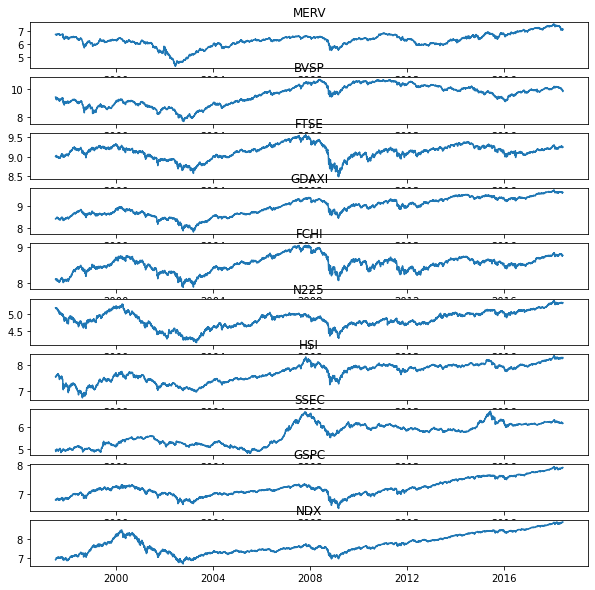

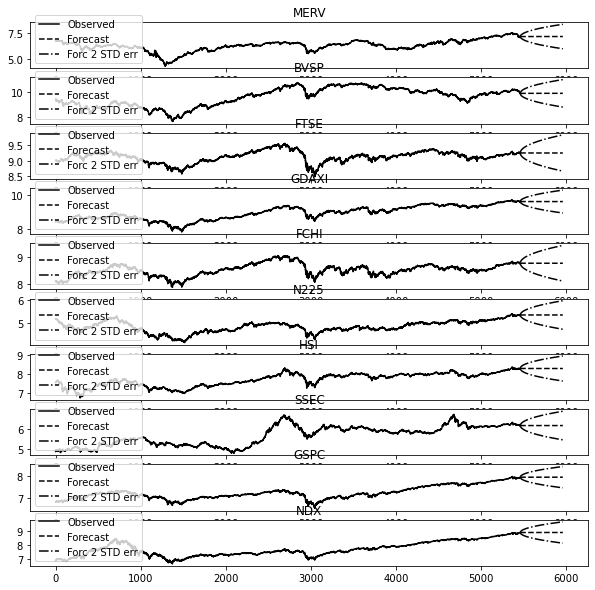

In [124]:
#vecm = VECM(endog = X_train, k_ar_diff = 9, coint_rank = 3, deterministic = ‘ci’)
#vecm_fit = vecm.fit()
#vecm_fit.predict(steps=10)

model = VECM(endog = ln_train_data, k_ar_diff = 1, coint_rank = 1, deterministic = "ci")
model_results = model.fit()
cointegration = model_results.coint_rank
print("Cointegration: ", cointegration)
model_results.plot_data()
model_results.plot_forecast(500)

In [125]:
#print(model_results.summary())

In [126]:
model_pred = model_results.predict(steps=n_test)
model_pred = (pd.DataFrame(model_pred, index=log_test_data.index, columns=log_test_data.columns + '_pred'))

In [127]:
model_pred

,MERV_pred,BVSP_pred,FTSE_pred,GDAXI_pred,FCHI_pred,N225_pred,HSI_pred,SSEC_pred,GSPC_pred,NDX_pred
FECHA,,,,,,,,,,
2018-06-11,7.128392,9.880329,9.242174,9.620047,8.768592,5.335912,8.285491,6.172152,7.929114,8.874262
2018-06-12,7.128707,9.880183,9.241504,9.619274,8.767835,5.336062,8.285296,6.172366,7.929141,8.874398
2018-06-13,7.128792,9.880331,9.241596,9.619362,8.767954,5.335891,8.285123,6.172320,7.929145,8.874411
2018-06-14,7.128857,9.880423,9.241529,9.619270,8.767880,5.335935,8.285082,6.172338,7.929172,8.874455
2018-06-15,7.128928,9.880524,9.241506,9.619225,8.767860,5.335921,8.285002,6.172338,7.929187,8.874483
...,...,...,...,...,...,...,...,...,...,...
2020-05-04,7.132008,9.884910,9.239989,9.616731,8.766355,5.335774,8.281763,6.172486,7.929985,8.875908
2020-05-05,7.132008,9.884910,9.239989,9.616731,8.766355,5.335774,8.281763,6.172486,7.929985,8.875908
2020-05-06,7.132008,9.884910,9.239989,9.616731,8.766355,5.335774,8.281763,6.172486,7.929985,8.875908


In [128]:
# Mean absolute error
mae = mean_absolute_error(log_test_data['MERV'], model_pred['MERV_pred'])
print('MAE: %f' % mae)

# Mean squared error
mse = mean_squared_error(log_test_data['MERV'], model_pred['MERV_pred'])
print('MSE: %f' % mse)

# Root mean squared error
rmse = math.sqrt(mse)
print('RMSE: %f' % rmse)

MAE: 0.608645
MSE: 0.487829
RMSE: 0.698447


Estuve probando con distintas combinaciones de "coint_rank" para ver si podía bajar el error, pero hasta ahora la mejor fue coint_rank = 1. Coincide con el análisis que hice del Test de Johanson (no sé si estatá bien), asique supongo que es la mejor opción del hiperparámetro. Pero, eso quiere decir que solo 2 series de las 10 que tenemos están correlacionadas, lo cual me hace un poco de ruido porque Sergio dijo que los mercados están relacionados entre sí.
Analizando las métricas de error de los modelos Baseline (Average y Naive) para la serie de logaritmos (ver abajo), podemos ver que no podemos mejorar las predicciones de dichos modelos base.

1. model_average_mean_squared_error :  0.28174
2. model_average_mean_absolute_error :  0.42556
3. model_average_median_absolute_error :  0.36331
4. model_naive_mean_squared_error :  0.00067
5. model_naive_mean_absolute_error :  0.01637
6. model_naive_median_absolute_error :  0.01121